# Co-incident loop

Here we simulate a survey and invert predicted data that uses a single transmitter and 3-component receiver. 

In [1]:
import discretize
from SimPEG import maps
from SimPEG.utils import plot2Ddata
import numpy as np
import matplotlib.pyplot as plt

import BTInvert
import uxo_utils

import polarizability_model as pm

from matplotlib import rcParams
rcParams["font.size"] = 14

In [2]:
# define system geometry -- transmitter is a horizontal square loop,
# receivers are in the centre, measure x, y, z data
sensorinfo = uxo_utils.CustomSensorInfo.coincident_system(
    tx_width=1., rx_width = 0.1
)
ordnance = uxo_utils.load_ordnance_dict()

In [3]:
# objects in the ordnance dictionary 
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

In [4]:
times = ordnance["ISO Small"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

## specify survey geometry

In [10]:
n_lines = 24
line_length = 3
line_spacing = 0.5*line_length/n_lines
survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.05,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, -1]*line_length/2,
    z=0.28,
    pitch=0,
    roll=0,
    yaw=0,
)

In [11]:
# survey_dict["yaw"] = survey_dict["yaw"]*0

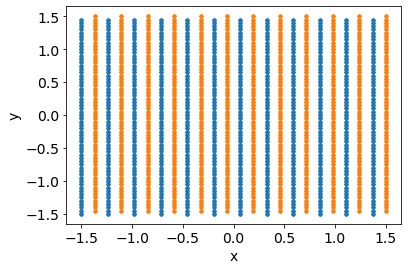

In [12]:
fig, ax = plt.subplots(1,1)

for l in np.unique(survey_dict["line"]): 
    inds = survey_dict["line"] == l
    ax.plot(
        survey_dict["pos"][inds, 0], survey_dict["pos"][inds, 1], ".", 
        color="C1" if np.all(survey_dict["yaw"][inds] > np.pi/2 ) else "C0"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

## set up parameters for forward simulation

In [13]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, 
    times, 
    mnum=survey_dict["mnum"], 
    pos=survey_dict["pos"], 
    pitch=survey_dict["pitch"], 
    roll=survey_dict["roll"], 
    yaw=survey_dict["yaw"]
)

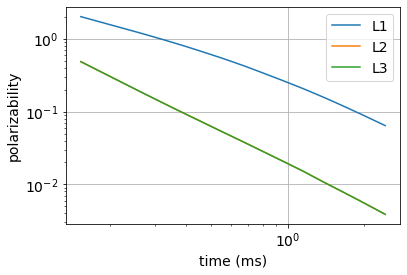

In [14]:
key = "ISO Small"
ind = 0  # there are multiple realizations of each in the library
ord_loc = np.r_[0, 0, -0.2]
ord_ypr = np.r_[0, 0, 0]

# Black Tusk likes to treat L1 as the largest, 
# which is opposite to the ordnance dictionary
L1, L2, L3 = (ordnance[key][l][ind] for l in ["L3", "L2", "L1"])

fig, ax = plt.subplots(1, 1)
for i, L in enumerate([L1, L2, L3]):
    ax.loglog(times, L, label=f"L{i+1}")

ax.grid()
ax.set_xlabel("time (ms)")
ax.set_ylabel("polarizability")
ax.legend();

## Run the simulation

In [15]:
data_uxo = uxo_utils.simulate_object(
    L1*0+1, L2*0+1, L3*0+1, fwd_params, times, ord_loc, ord_ypr
)

In [19]:
def plot_data_profile(data, line_id=0, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    inds = survey_dict["line"].reshape(survey_dict["xyz"].shape)[:, 0] == line_id
    for i, comp in enumerate(["x", "y", "z"]):
        ax[i].plot(
            survey_dict["xyz"][inds, 1], data_uxo[i, inds, :], "-o", label=comp, 
            ms=2, color="k", alpha=0.4
        )
        ax[i].set_title(f"{comp}-component")
        ax[i].set_xlabel("along line (m)")

    ax[0].set_ylabel("db/dt (mV)")

    plt.tight_layout()
    return ax

In [20]:
data_uxo.shape

(3, 1440, 27)

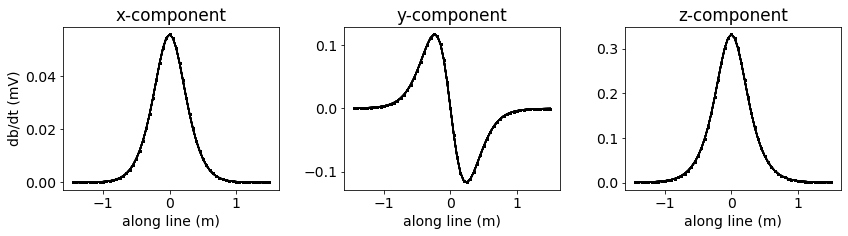

In [21]:
plot_data_profile(data_uxo, 11);

In [22]:
def plot_data_maps(data, n=40, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(14, 4)) 
    for i, title in enumerate(["x", "y", "z"]):
        d = data[i::3]
        contour_opts = {
            "vmin": -1*np.max(np.abs(d)),
            "vmax": np.max(np.abs(d)),
            "cmap": "Spectral_r"
        }
        plt.colorbar(plot2Ddata(
            survey_dict["xyz"], d, ax=ax[i],
            nx=n, ny=n, contourOpts=contour_opts
        )[0], ax=ax[i])
        ax[i].set_title(title)

    plt.tight_layout()
    return ax


In [23]:
data_uxo.shape

(3, 1440, 27)

In [33]:
np.cos(np.pi)

-1.0

In [34]:
# inds_rotate = survey_dict["yaw"][::3] > 0
data_uxo_rotated = data_uxo.copy()
data_uxo_rotated[0, :, :] = data_uxo_rotated[0, :, :] * np.cos(survey_dict["yaw"][::3])[:, None]
data_uxo_rotated[1, :, :] = data_uxo_rotated[1, :, :] * np.cos(survey_dict["yaw"][1::3])[:, None]

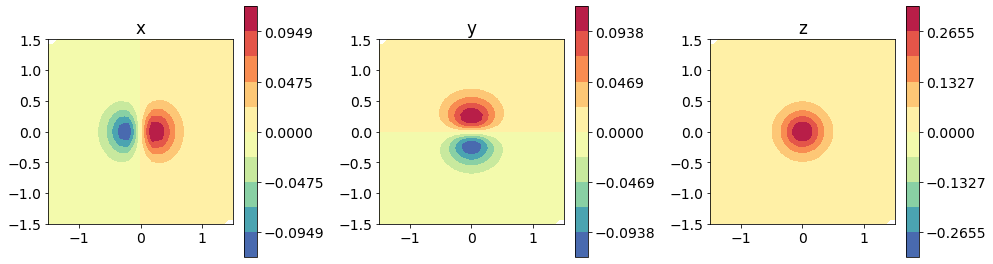

In [35]:
plot_data_maps(data_uxo_rotated[:, :, 2].T.flatten());

# set up inversion

In [36]:
core_domain = line_length # meters
nc = 32
dx = core_domain/nc
npad = 5
pf = 1.
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")
mesh.n_cells

1764

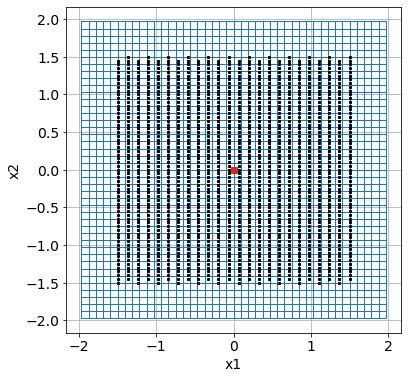

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

mesh.plot_grid(ax=ax, linewidth=1)
ax.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.k', alpha=0.8, ms=4)
ax.plot(ord_loc[0], ord_loc[1], 's',color="C3", ms=6)

In [38]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])

In [39]:
src_list = []
nrx = len(sensorinfo.receivers)

for i, txi in enumerate(survey_dict["txnum"]):
    tx = sensorinfo.transmitters[txi]
    tx_corners = tx.shape + survey_dict["xyz"][i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receivers = pm.MagneticFluxDensityReceiver(
        np.atleast_2d(survey_dict["xyz"][i, :]), 
        components=[rx.component for rx in sensorinfo.receivers]
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=1
    )
    src_list.append(src)

In [41]:
src.receiver_list[0].locations

array([[ 1.5 , -1.45,  0.28]])

In [42]:
survey = pm.Survey(src_list)
survey.nD

4320

In [43]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

## run inversion 

In [44]:
data_uxo.shape

(3, 1440, 27)

In [45]:
t_invert = 0  # time channel to invert

# grab time channel of interest, flatten so order is by transmitter, then receiver
d_invert = data_uxo_rotated[:, :, t_invert].T
d_invert = d_invert.flatten()


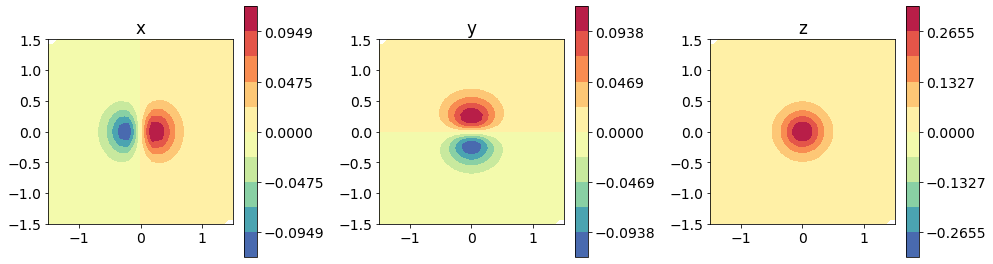

In [46]:
plot_data_maps(d_invert);

### simple inversion that doesn't enforce positivity

In [47]:
noise_floor = 0.01 * np.max(np.abs(d_invert))

In [48]:
inversion_test = pm.Inversion(sim, d_invert, noise_floor, beta=None)

In [49]:
mrec0 = inversion_test.solve(beta_fact=1)

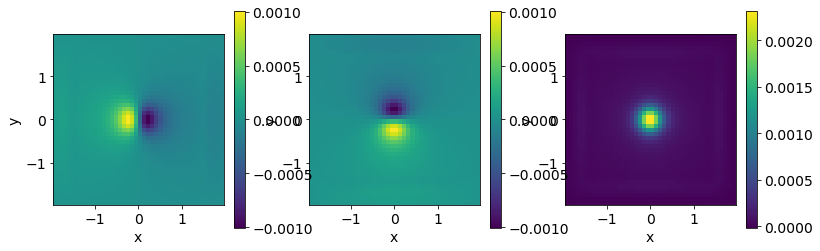

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec0[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

### inversion with SimPEG 

In [51]:
from SimPEG import (
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives, Data, maps
)

In [52]:
dmis = data_misfit.L2DataMisfit(
    data=Data(
        survey, dobs=d_invert, 
        noise_floor=noise_floor, 
        relative_error=0.05
    ), 
    simulation=sim
)

nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

opt = optimization.ProjectedGNCG(maxIterCG=40, lower=0, maxIter=20) 
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 

In [53]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [54]:
inv = inversion.BaseInversion(invprob, directive_list)

In [60]:
mrec = inv.run(np.zeros(mesh.nC*3)+1e-10)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.03e+08  5.45e+04  2.65e-17  5.45e+04    3.76e+06      0   Skip BFGS  
   1  2.01e+08  3.27e+04  2.28e-05  3.73e+04    1.36e+06      0   Skip BFGS  
   2  1.01e+08  2.26e+04  5.88e-05  2.86e+04    1.09e+06      0   Skip BFGS  
   3  5.04e+07  1.33e+04  1.25e-04  1.96e+04    7.97e+05      0   Skip BFGS  
   4  2.52e+07  6.56e+03  2.19e-04  1.21e+04    5.27e+05      0   Skip BFGS  
   5  1.26e+07  2.89e+03  3.20e-04  6.91e+03    3.18e+05      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 5.4458e+

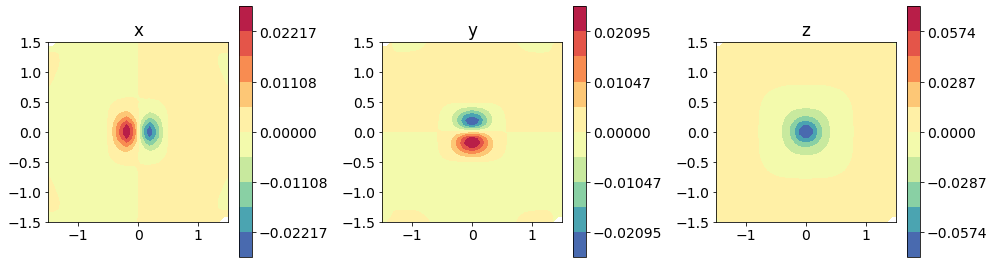

In [61]:
plot_data_maps((invprob.dpred - d_invert));

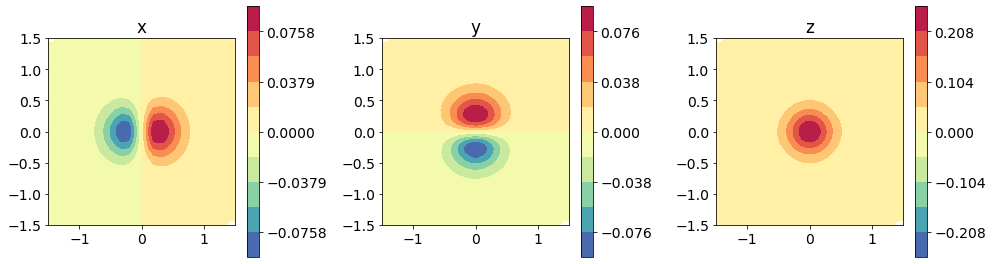

In [62]:
plot_data_maps(invprob.dpred);

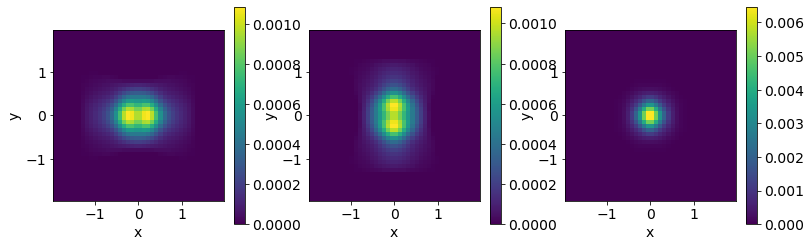

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [64]:
dmis.test(x = np.random.rand(mesh.nC*3), num=8) 

Testing L2DataMisfit Deriv
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.125e+09     1.143e+08      nan
 1   1.00e-02    1.228e+08     1.143e+06      2.000
 2   1.00e-03    1.239e+07     1.143e+04      2.000
 3   1.00e-04    1.240e+06     1.143e+02      2.000
 4   1.00e-05    1.240e+05     1.143e+00      2.000
 5   1.00e-06    1.240e+04     1.145e-02      1.999
 6   1.00e-07    1.240e+03     1.071e-04      2.029
 7   1.00e-08    1.240e+02     1.376e-05      0.891
========================= PASS! =========================
Go Test Go!

Testing L2DataMisfit Deriv2
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.420e+09     1.907e-05      nan
 1   1.00e-02    2.420e+08     1.413e-05      0.130
 2   1.00e-03    2.420e+

False